In this notebook we will download the raw data, create for each of the currencies its own table with the history of prices. After that we quantize the values with a `300ms` window using various aggregation functions, save the obtained values in `data/quantized`.

**need to  add readme for installing dataset from drive**

# Start 
### raw data loading and initial analysis

In [1]:
import sys
import pickle
import pandas as pd
import numpy as np
from multiprocessing import Pool

In [2]:
sys.path.append('../src')

In [3]:
PATH_FROM = '../data/raw/'
TARGET_SHORT_NAME = 'chz_usdt_perp_midprice_v2_short.pkl'
DATA_SHORT_NAME = 'trades_v2_short.pkl'
TARGET_NAME = 'CHZ_USDT_PERP_MIDPRICE'

In [4]:
%%time
target = pickle.load(open(PATH_FROM + TARGET_SHORT_NAME, 'rb'))
df = pickle.load(open(PATH_FROM + DATA_SHORT_NAME, 'rb'))

CPU times: user 1.81 s, sys: 1.3 s, total: 3.11 s
Wall time: 3.4 s


In [5]:
target.describe()

,CHZ_USDT_PERP_MIDPRICE
count,2.372317e+06
mean,2.099565e-01
std,9.363737e-03
min,1.936200e-01
25%,2.009650e-01
50%,2.110900e-01
75%,2.182400e-01
max,2.283800e-01


In [6]:
target.head(3)

,CHZ_USDT_PERP_MIDPRICE
2022-11-15 00:00:00.029243,0.198425
2022-11-15 00:00:00.251378,0.198410
2022-11-15 00:00:00.252974,0.198395


<AxesSubplot: title={'center': 'TARGET CURRENCY'}, xlabel='TIME', ylabel='MIDPRICE'>

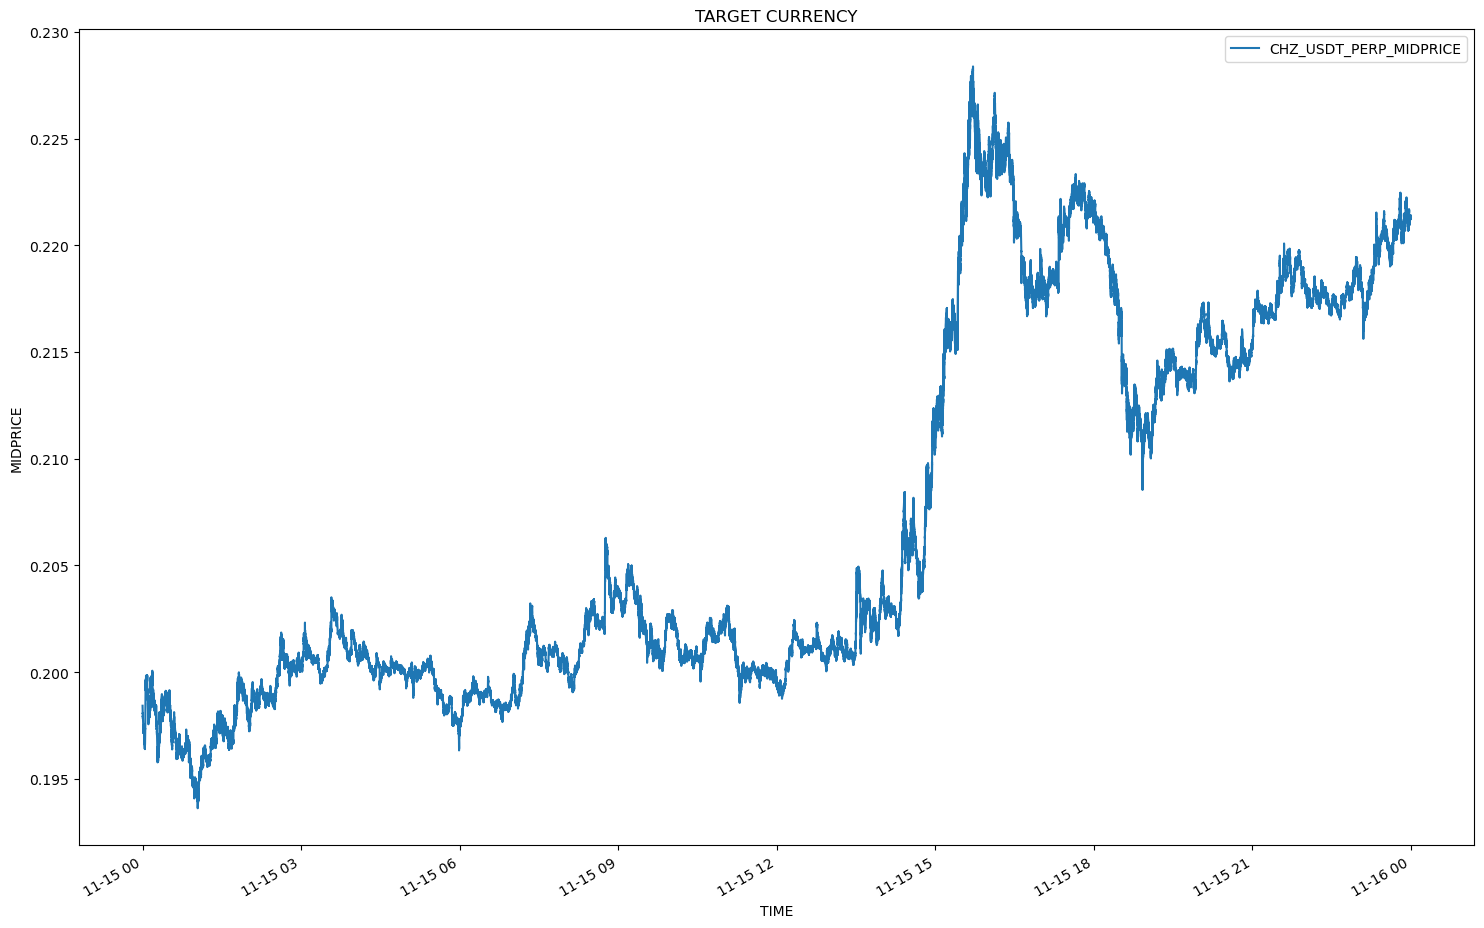

In [7]:
target.plot(y='CHZ_USDT_PERP_MIDPRICE', figsize=(18,12), title='TARGET CURRENCY', ylabel='MIDPRICE', xlabel='TIME')

**Fig.1. We see that the data is for November 15. During the day there is a linear increase in price, but around 16:00 there is an anomalous jump.**

In [8]:
print(f'The size of target table is {target.shape[0]}')

The size of target table is 2372317


In [9]:
df.describe()

,price,quantity
count,5.054018e+07,5.054018e+07
mean,1.933923e+03,2.593011e+03
std,5.120755e+03,2.991904e+04
min,6.500000e-04,1.000000e-03
25%,3.146000e-01,1.400000e+00
50%,2.011000e+00,4.200000e+01
75%,1.202100e+02,4.520000e+02
max,1.712720e+04,4.000000e+07


In [10]:
df.head(7)

,event_time,ex_time,price,quantity,is_buy,symbol
0,2022-11-15 00:00:00.287594,2022-11-15 00:00:00.282,0.1735,441.0,1,1000LUNC_USDT_PERP
1,2022-11-15 00:00:00.287614,2022-11-15 00:00:00.282,0.1735,31.0,1,1000LUNC_USDT_PERP
2,2022-11-15 00:00:00.287620,2022-11-15 00:00:00.282,0.1735,355.0,1,1000LUNC_USDT_PERP
3,2022-11-15 00:00:00.287784,2022-11-15 00:00:00.283,0.1735,1023.0,1,1000LUNC_USDT_PERP
4,2022-11-15 00:00:00.292314,2022-11-15 00:00:00.287,0.1735,498.0,1,1000LUNC_USDT_PERP
5,2022-11-15 00:00:00.292349,2022-11-15 00:00:00.287,0.1735,35.0,1,1000LUNC_USDT_PERP
6,2022-11-15 00:00:05.841978,2022-11-15 00:00:04.410,0.1736,103.0,1,1000LUNC_USDT_PERP


In [11]:
print(f'The size of trades table is {df.shape[0]}')

The size of trades table is 50540181


In [12]:
names = df['symbol'].unique()
print(f'The number of unique currencies {len(names)}\nThe first 3 of them:')
for name in names[:3]:
    print(name)

The number of unique currencies 175
The first 3 of them:
1000LUNC_USDT_PERP
1000SHIB_USDT_PERP
1000XEC_USDT_PERP


We can see that the number of unique currencies is **very high**. To do this, let's save the information for each of them in **separate** tables.

Some functions have been implemented inside the `preprocessing_utils` module. 
Let's use them. 

In [13]:
import preprocessing_utils

In [14]:
help(preprocessing_utils.separate_and_save)

Help on function separate_and_save in module preprocessing_utils:

separate_and_save(df: pandas.core.frame.DataFrame, names: List[str], sep_col: str = 'symbol', path_to_save: str = 'data/') -> None
    Splits the table into several small tables according to the value
    of the 'sep_col' column.
    
    :param df: a large table, which must be divided into several smaller ones
    :param names: the values of the 'sep_col' column for which the tables
    are to be saved
    :param sep_col: the name of the column by which we want to split the table
    :param path_to_save: the address where we want to save the tables
    :return: nothing is returned, separated tables by 'sep_col' column values
    from the 'names' list are saved to the address 'path_to_save' in csv format



In [15]:
%%time
pd.options.mode.chained_assignment = None
preprocessing_utils.separate_and_save(df=df,
                                names=names,
                                sep_col='symbol',
                                path_to_save='../data/separated')

CPU times: user 5min 22s, sys: 5.33 s, total: 5min 27s
Wall time: 5min 31s


# Quantization
### reduce the size of the data by aggregating the information over some time interval

In [16]:
separated_df_dict = preprocessing_utils.load_tables(names=names,
                                              path_from='../data/separated')

In [17]:
separated_df_dict[names[0]].head(2)

,ex_time,price,quantity,is_buy,symbol,money_buy,money_sell,is_not_buy
event_time,,,,,,,,
2022-11-15 00:00:00.287594,2022-11-15 00:00:00.282,0.1735,441.0,1,1000LUNC_USDT_PERP,76.5135,0.0,0
2022-11-15 00:00:00.287614,2022-11-15 00:00:00.282,0.1735,31.0,1,1000LUNC_USDT_PERP,5.3785,0.0,0


Since the trades in different currencies are not coordinated in time, we **quantize** the entire time series for each of the currencies. This will also allow us to **reduce** the dimensionality of the data and formalize the notion of price in `300ms` (*this is the average price we saw in the following `300ms` size window*). Since the quantization process of each of the currencies can be performed **independently** of the others, we can **parallelize** it.

For this we will use the `quantize_table` function:

In [18]:
help(preprocessing_utils.quantize_table)

Help on function quantize_table in module preprocessing_utils:

quantize_table(df: pandas.core.frame.DataFrame, freq: str = '300ms') -> pandas.core.frame.DataFrame
    Returns a dataframe quantized by 'freq'-sized windows . Inside each window it calculates
    some statistics (mean, median, standard deviation, and others).
    
    :param df: unprocessed dataframe
    :param freq: quantization window width
    :return: quantized dataframe with some statistics



In [19]:
%%time
n_cores = 8
pool = Pool(n_cores)
with Pool(n_cores) as p:
    res = p.starmap(preprocessing_utils.quantize_table, [(separated_df_dict[name], '300ms') for name in names])
df_quantized_dict = {name: res[i] for i, name in enumerate(names)}

# we quantize the target table separately, because it has a different scheme
target['event_time'] = pd.to_datetime(target.index)
target = target.set_index('event_time')
df_quantized_dict[TARGET_NAME] = target.groupby(
    pd.Grouper(freq='300ms',
               origin='start_day')).agg(price_mean=(TARGET_NAME, np.mean))

CPU times: user 26.4 s, sys: 16.7 s, total: 43 s
Wall time: 5min 7s


In [20]:
preprocessing_utils.save_tables(df_quantized_dict, df_quantized_dict.keys(), '../data/quantized')

# Results

### unified price format for all currencies and reduced table sizes

In [21]:
df_quantized_dict[names[0]].tail(3)

,price_mean,price_median,price_std,buy_price_sum,sell_price_sum,nonzero_count,buy_count,sell_count
event_time,,,,,,,,
2022-11-15 23:59:59.100,0.1839,0.1839,0.0,747.9213,0.0000,5,5,0
2022-11-15 23:59:59.400,NaN,NaN,NaN,0.0000,0.0000,0,0,0
2022-11-15 23:59:59.700,0.1839,0.1839,0.0,0.0000,999.6804,2,0,2


In [22]:
df_quantized_dict[TARGET_NAME].tail(3)

,price_mean
event_time,
2022-11-15 23:59:58.800,0.221298
2022-11-15 23:59:59.100,0.221291
2022-11-15 23:59:59.400,0.221298


In [23]:
target_shape = df_quantized_dict[TARGET_NAME].shape[0]
data_shape = df_quantized_dict[names[0]].shape[0]
print(f' The size of the quantized target currency table is {target_shape},\n',
      f'the size of the quantized table of the other currency is {data_shape}')

 The size of the quantized target currency table is 287999,
 the size of the quantized table of the other currency is 288000


We can see that the size of the tables **has decreased a lot** and now the data are **almost consistent** (they differ in a few extreme windows of size `300ms`).

In [24]:
target_table = df_quantized_dict[TARGET_NAME]
nan_val = sum(target_table['price_mean'].isnull())
print(f'The number of nan in target table is {nan_val}.\nThis is {round(100*nan_val/target_table.shape[0], 1)}% of the target table')

The number of nan in target table is 89910.
This is 31.2% of the target table


We see that the quantization inevitably generates `Nans` (even if they were not in the original dataset), because not all `300ms` windows were traded. 
In the next notebook `extract_feature_notebook` we will fight with this and build features.